# Exploring the coral data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt 
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random


In [2]:
# Import coral data

coral_data = pd.read_csv('/Users/maikentomren/Documents/prosjektoppgave/plotting git/Illuminating-the-deep---projections-/coral_data.csv')


#coral_data = gpd.read_file('./processed_data/coral_data_trondelag_processed.parquet')

#nor4km_coral_data = gpd.read_file('./processed_data/nor4km_coral_data_trondelag_processed.parquet')

#midnor_coral_data = gpd.read_file('./processed_data/midnor_coral_data_trondelag_processed.parquet')

# gml_file_coral_reefs = "./KystOgFiskeri_50_Trondelag_25832_Korallrev_GML.gml"
#gml_file_coral_reefs = "./raw_data/KystOgFiskeri_50_Trondelag_25833_Korallrev_GML.gml"
#coral_data = gpd.read_file(gml_file_coral_reefs)

print(coral_data.columns)

Index(['lengdegrad', 'breddegrad', 'x', 'y'], dtype='object')


In [3]:
coral_data.head()   #already transformed 

coral_x = coral_data['x']
coral_y = coral_data['y']

# Exploring SINMOD data

- PCA

In [4]:

# Importing SINMOD data

filename_PhysStates = 'PhysStates.nc' 

PhysStates_data = Dataset(filename_PhysStates, 'r')

filename_BioStates = '/Users/maikentomren/Documents/prosjektoppgave/plotting git/Illuminating-the-deep---projections-/BioStates.nc'

BioStates_data = Dataset(filename_BioStates, 'r')




#filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/gin/spinup/run2/PhysStates.nc'

#PhysStates_data = Dataset(filename_PhysStates, 'r')

#filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/nor4km_2019/2019/PhysStates.nc'

#nor4km_PhysStates_data = Dataset(filename_PhysStates, 'r')

#filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'

#midnor_PhysStates_data = Dataset(filename_PhysStates, 'r')

# Exploring SINMOD and Coral data

- Histograms of features at coral data locations (and randomly sampled histograms)
- PLS


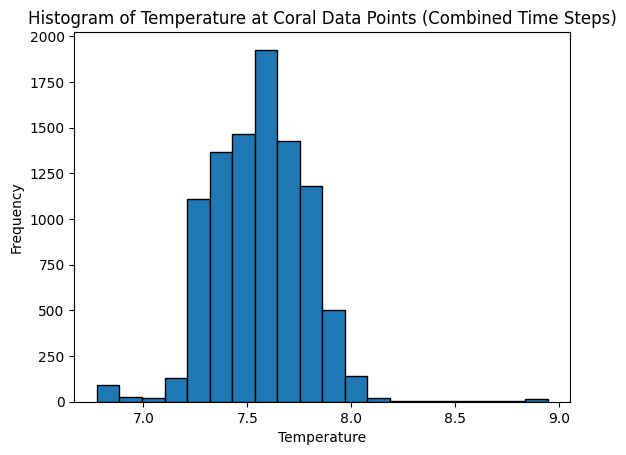

Number of valid coordinates: 63.0 out of 104


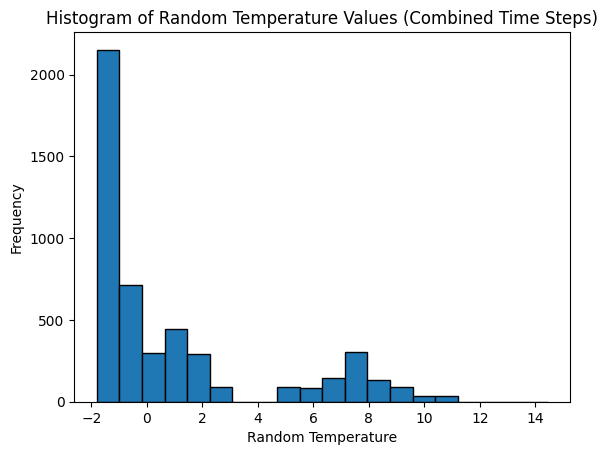

Number of valid random coordinates: 32.666666666666664 out of 104
Statistics for coral values: {'mean': np.float32(7.560563), 'max': np.float32(8.94528), 'min': np.float32(6.7766953), '90th_percentile': np.float32(7.8280582), '10th_percentile': np.float32(7.290079)}


In [5]:
# Now plot histogram of temperature values at coral data points

def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, generate_random=False):

    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    t_start, t_stop = t_range

    # Extract variable values at coral data points
    coral_values = []
    valid_coordinates = []

    for time in range(t_start, t_stop):

        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            
            # Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                if variable_name == 'current_speed':
                    value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                else:
                    value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values.append(value)
                    valid_coordinates.append((int(x), int(y)))

    # Convert list to numpy array for easier manipulation
    coral_values = np.array(coral_values)

    # Flatten the array to combine all time steps
    coral_values_flat = coral_values.flatten()

    # Plot histogram of the combined variable values
    plt.hist(coral_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points (Combined Time Steps)')
    plt.show()

    print(f"Number of valid coordinates: {len(valid_coordinates)/(t_stop - t_start)} out of {len(coral_data)}")

    if generate_random:
        # Plotting random histogram

        no_points = int(len(valid_coordinates)/(t_stop - t_start))

        # Generate same number of valid co-ords as random x and y locations within the grid
        valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150))

        selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

        random_values = []
        random_valid_coordinates = 0

        for time in range(t_start, t_stop):

            for y, x in selected_indices:
                # Ensure the coordinates are within the grid bounds
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    random_depth = random.uniform(100, depth_at_point)
                    layer_index = np.searchsorted(cumulative_depth, random_depth)

                    if variable_name == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                    
                    else:
                        value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        random_valid_coordinates += 1
        
        # Convert list to numpy array for easier manipulation
        random_values = np.array(random_values)

        # Flatten the array to combine all time steps
        random_values_flat = random_values.copy().flatten()

        # Plot histogram of the combined random variable values
        plt.hist(random_values_flat, bins=20, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values (Combined Time Steps)')
        plt.show()

        print(f"Number of valid random coordinates: {random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")

        # Calculate statistics for coral values
        stats = {
            'mean': np.mean(coral_values_flat),
            'max': np.max(coral_values_flat),
            'min': np.min(coral_values_flat),
            '90th_percentile': np.percentile(coral_values_flat, 90),
            '10th_percentile': np.percentile(coral_values_flat, 10)
        }

        print(f"Statistics for coral values: {stats}")

        return stats, coral_values_flat, random_values_flat, coral_values
    return coral_values_flat, coral_values

# Example usage
# plot_histogram_at_coral_points(PhysStates_data, coral_data, 'temperature', (0, 50))
# plot_histogram_at_coral_points(nor4km_PhysStates_data, nor4km_coral_data, 'temperature', (0, 50))
#midnor_stats = plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'temperature', (0, 50), True)
stats_temp, coral_values_temp_flat, random_values_temp_flat, coral_values_temp = plot_histogram_at_coral_points(PhysStates_data, coral_data, 'temperature', (0, 150), True)
# plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'salinity', (0, 50))

In [ ]:
# Now plot histogram of temperature values at coral data points

def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, generate_random=False):

    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    t_start, t_stop = t_range

    # Extract variable values at coral data points
    coral_values = np.ndarray(shape=(len(x), len(range(t_start, t_stop))))

    valid_coordinates = []
    
    for i, x, y in enumerate(zip(coral_data['x']/hor_res, coral_data['y']/hor_res)):
        
        for j, time in enumerate(range(t_start, t_stop)):

            
            # Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                if variable_name == 'current_speed':
                    value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                else:
                    value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values[i, j] = value
                    valid_coordinates.append((int(x), int(y)))


    
   
    if generate_random:
        # Plotting random histogram

        no_points = int(len(valid_coordinates)/(t_stop - t_start))

        # Generate same number of valid co-ords as random x and y locations within the grid
        valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150))

        selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

        random_values = []
        random_valid_coordinates = 0

        for time in range(t_start, t_stop):

            for y, x in selected_indices:
                # Ensure the coordinates are within the grid bounds
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    random_depth = random.uniform(100, depth_at_point)
                    layer_index = np.searchsorted(cumulative_depth, random_depth)

                    if variable_name == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                    
                    else:
                        value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        random_valid_coordinates += 1
        
        # Convert list to numpy array for easier manipulation
        random_values = np.array(random_values)

        # Flatten the array to combine all time steps
        random_values_flat = random_values.copy().flatten()

        # Plot histogram of the combined random variable values
        plt.hist(random_values_flat, bins=20, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values (Combined Time Steps)')
        plt.show()

        print(f"Number of valid random coordinates: {random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")

        # Calculate statistics for coral values
        stats = {
            'mean': np.mean(coral_values_flat),
            'max': np.max(coral_values_flat),
            'min': np.min(coral_values_flat),
            '90th_percentile': np.percentile(coral_values_flat, 90),
            '10th_percentile': np.percentile(coral_values_flat, 10)
        }

        print(f"Statistics for coral values: {stats}")

        return stats, coral_values_flat, random_values_flat, coral_values
    return coral_values_flat, coral_values

# Example usage
# plot_histogram_at_coral_points(PhysStates_data, coral_data, 'temperature', (0, 50))
# plot_histogram_at_coral_points(nor4km_PhysStates_data, nor4km_coral_data, 'temperature', (0, 50))
#midnor_stats = plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'temperature', (0, 50), True)
stats_temp, coral_values_temp_flat, random_values_temp_flat, coral_values_temp = plot_histogram_at_coral_points(PhysStates_data, coral_data, 'temperature', (0, 150), True)
# plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'salinity', (0, 50))

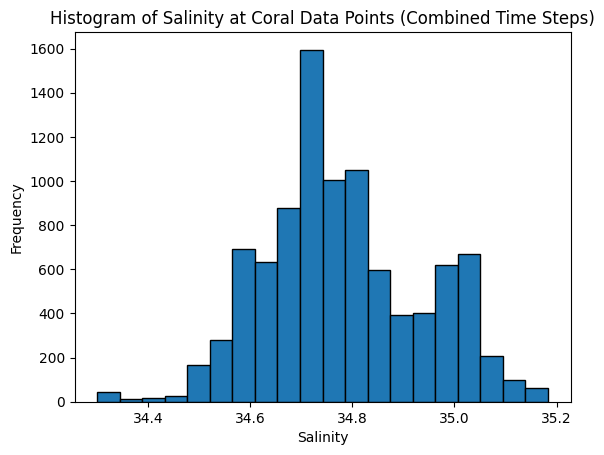

Number of valid coordinates: 63.0 out of 104


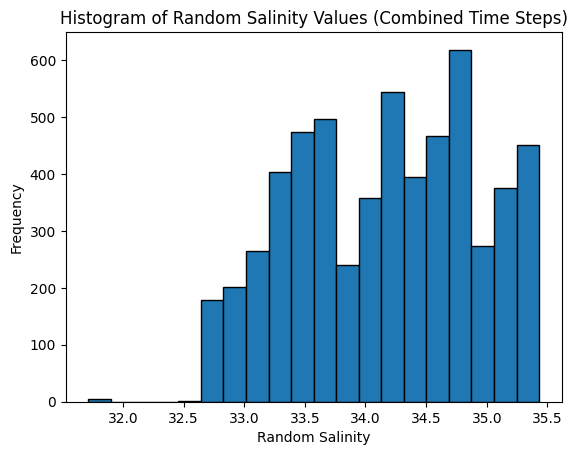

Number of valid random coordinates: 38.27333333333333 out of 104
Statistics for coral values: {'mean': np.float32(34.78006), 'max': np.float32(35.183266), 'min': np.float32(34.29975), '90th_percentile': np.float32(35.01007), '10th_percentile': np.float32(34.582813)}


In [20]:
stats_salinity, coral_values_salinity_flat, random_values_salinity_flat, coral_values_salinity = plot_histogram_at_coral_points(PhysStates_data, coral_data, 'salinity', (0, 150), True)



/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/3700275841.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)


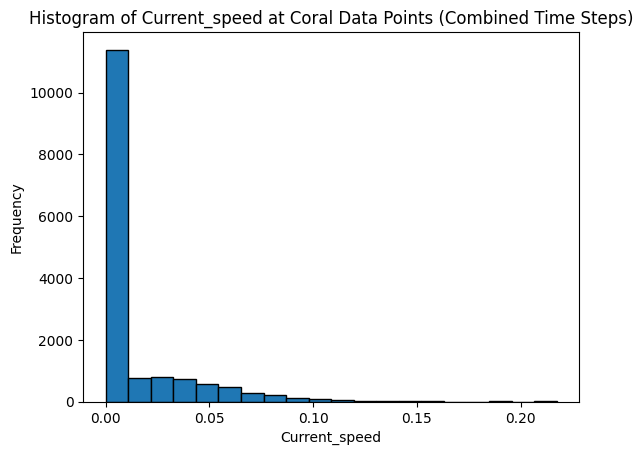

Number of valid coordinates: 104.0 out of 104


/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/3700275841.py:76: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)


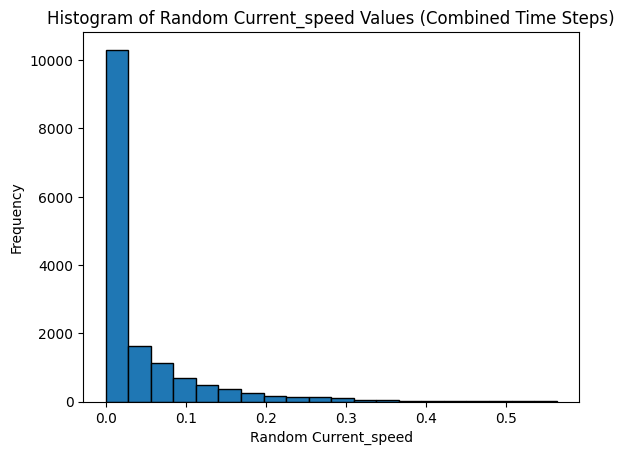

Number of valid random coordinates: 104.0 out of 104
Statistics for coral values: {'mean': np.float64(0.012729261892561156), 'max': np.float64(0.21729178726673126), 'min': np.float64(0.0), '90th_percentile': np.float64(0.05005407705903053), '10th_percentile': np.float64(0.0)}


In [19]:
hist, stats_current_speed, coral_values_current_speed_flat, random_values_current_speed_flat = plot_histogram_at_coral_points(PhysStates_data, coral_data, 'current_speed', (0, 150), True)



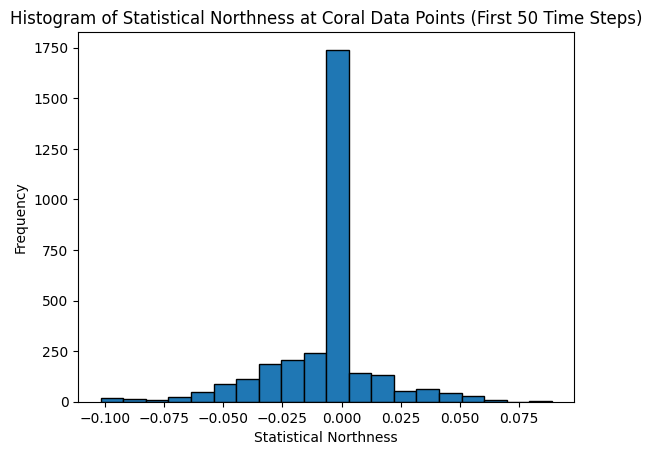

Number of valid coordinates: 63.0 out of 104


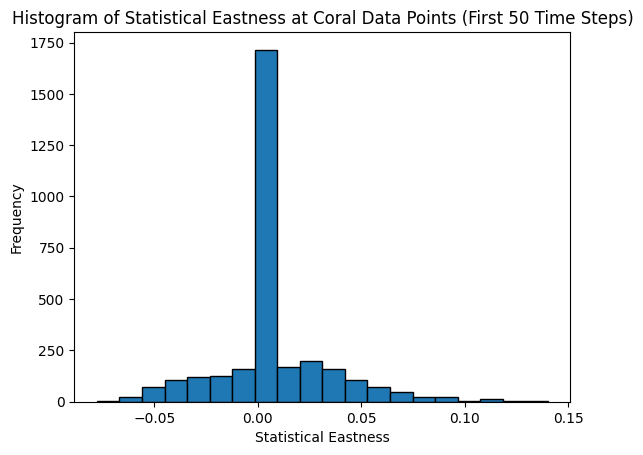

Number of valid coordinates: 63.0 out of 104


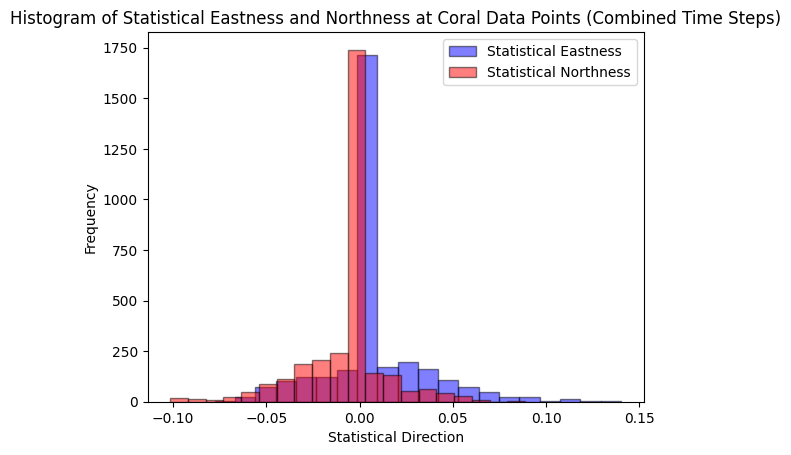

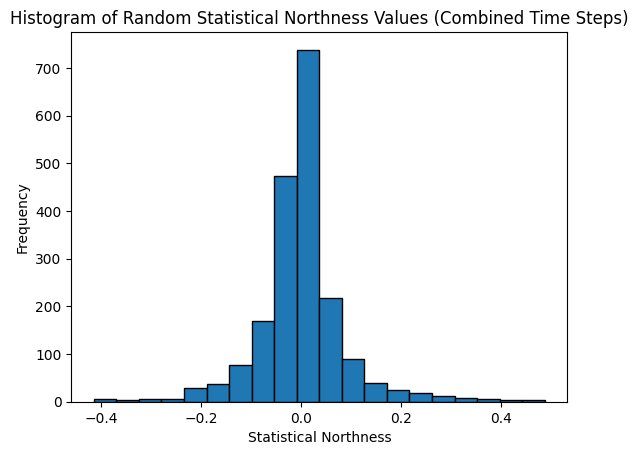

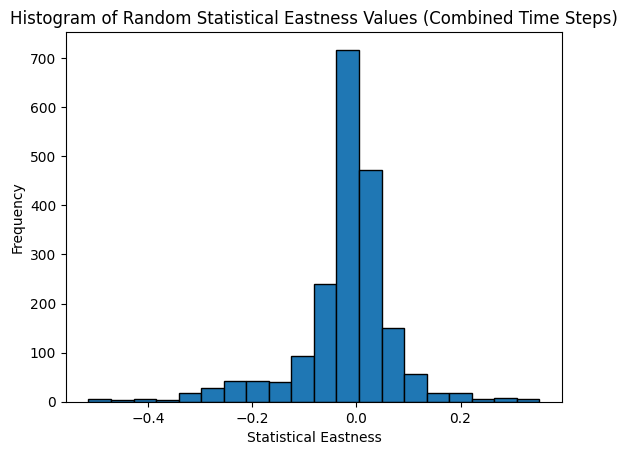

Number of valid random coordinates north: 39.32 out of 104
Number of valid random coordinates east: 39.32 out of 104


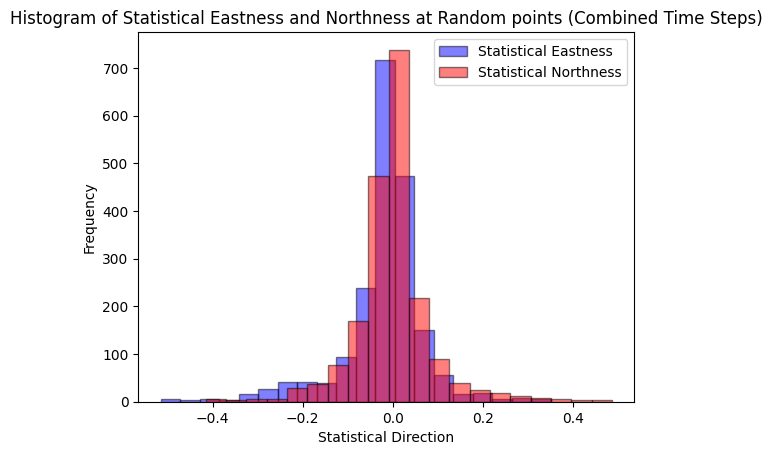

In [16]:
#Extracting current direction (statistical eastness and northness) components at depth closest to 250m

#need to run on idun!

# Calculate eastward and northward components of current velocity
# Using the first 150 time steps
eastward_velocity = PhysStates_data.variables['u_velocity'][:50] * np.cos(np.deg2rad(58)) - PhysStates_data.variables['v_velocity'][:50] * np.sin(np.deg2rad(58))
northward_velocity = PhysStates_data.variables['u_velocity'][:50] * np.sin(np.deg2rad(58)) + PhysStates_data.variables['v_velocity'][:50] * np.cos(np.deg2rad(58))

# Convert eastward and northward components to statistical northness and eastness
statistical_northness = northward_velocity* np.cos(np.deg2rad(90)) - eastward_velocity * np.sin(np.deg2rad(90))
statistical_eastness = northward_velocity * np.sin(np.deg2rad(90)) + eastward_velocity * np.cos(np.deg2rad(90))

zc = PhysStates_data.variables['LayerDepths'][:]
cumulative_depth = np.cumsum(zc, axis=0)

xc_max = PhysStates_data.variables['xc'].shape[0]
yc_max = PhysStates_data.variables['yc'].shape[0]

hor_res = PhysStates_data.variables['grid_mapping'].getncattr('horizontal_resolution')

# Extract variable values at coral data points
coral_values_north = []
coral_values_east = []
valid_coordinates_north = []
valid_coordinates_east = []


for time in range(0, 50):

        for x, y in zip(coral_x/hor_res, coral_y/hor_res):
            
            # Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = PhysStates_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                
                value_north = statistical_northness[time, layer_index, int(y), int(x)]
                value_east = statistical_eastness[time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value_north):
                    coral_values_north.append(value_north)
                    valid_coordinates_north.append((int(x), int(y)))

                if not np.ma.is_masked(value_east):
                    coral_values_east.append(value_east)
                    valid_coordinates_east.append((int(x), int(y)))



# Convert list to numpy array for easier manipulation
coral_values_north = np.array(coral_values_north)
coral_values_east = np.array(coral_values_east)

# Flatten the array to combine all time steps
coral_values_north_flat = coral_values_north.flatten()
coral_values_east_flat = coral_values_east.flatten()

# Plot histogram of the combined variable values
plt.hist(coral_values_north_flat, bins=20, edgecolor='black')
plt.xlabel('Statistical Northness')
plt.ylabel('Frequency')
plt.title('Histogram of Statistical Northness at Coral Data Points (First 50 Time Steps)')
plt.show()

print(f"Number of valid coordinates: {len(valid_coordinates_north)/(50)} out of {len(coral_data)}")


plt.hist(coral_values_east_flat, bins=20, edgecolor='black')
plt.xlabel('Statistical Eastness')
plt.ylabel('Frequency')
plt.title('Histogram of Statistical Eastness at Coral Data Points (First 50 Time Steps)')
plt.show()

print(f"Number of valid coordinates: {len(valid_coordinates_east)/(50)} out of {len(coral_data)}")


# Plot histogram of the combined statistical eastness and northness values
plt.hist(coral_values_east_flat, bins=20, edgecolor='black', color='blue', alpha=0.5, label='Statistical Eastness')
plt.hist(coral_values_north_flat, bins=20, edgecolor='black', color='red', alpha=0.5, label='Statistical Northness')
plt.xlabel('Statistical Direction')
plt.ylabel('Frequency')
plt.title('Histogram of Statistical Eastness and Northness at Coral Data Points (Combined Time Steps)')
plt.legend()
plt.show()


 

# Plotting random histogram

no_points_east = int(len(valid_coordinates_east)/(50))
no_points_north = int(len(valid_coordinates_north)/(50))   

# Generate same number of valid co-ords as random x and y locations within the grid
valid_xc_yc_indices = np.argwhere(np.logical_and(~PhysStates_data.variables['temperature'][0,0].mask, PhysStates_data.variables['depth'][:] <=275,  PhysStates_data.variables['depth'][:] >= 150))

selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points_east, replace=False)]

random_values_north = []
random_valid_coordinates_north = 0

random_values_east = []
random_valid_coordinates_east = 0


for time in range(0, 50):

    for y, x in selected_indices:
        # Ensure the coordinates are within the grid bounds
        if 0 <= x <= xc_max and 0 <= y <= yc_max:
            depth_at_point = PhysStates_data.variables['depth'][int(y), int(x)]
            random_depth = random.uniform(100, depth_at_point)
            layer_index = np.searchsorted(cumulative_depth, random_depth)

            
            eastward_velocity = PhysStates_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(58)) - PhysStates_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(58))
            northward_velocity = PhysStates_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(58)) + PhysStates_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(58))
            value_north = northward_velocity* np.cos(np.deg2rad(90)) - eastward_velocity * np.sin(np.deg2rad(90))    
            value_east = northward_velocity * np.sin(np.deg2rad(90)) + eastward_velocity * np.cos(np.deg2rad(90))
                
        
            if not np.ma.is_masked(value_north):
                random_values_north.append(value_north)
                random_valid_coordinates_north += 1

            if not np.ma.is_masked(value_east):
                random_values_east.append(value_east)
                random_valid_coordinates_east += 1
    
# Convert list to numpy array for easier manipulation
random_values_north = np.array(random_values_north)
random_values_east = np.array(random_values_east)

# Flatten the array to combine all time steps
random_values_north_flat = random_values_north.flatten()
random_values_east_flat = random_values_east.flatten()

# Plot histogram of the combined random variable values
plt.hist(random_values_north_flat, bins=20, edgecolor='black')
plt.xlabel('Statistical Northness')
plt.ylabel('Frequency')
plt.title(f'Histogram of Random Statistical Northness Values (Combined Time Steps)')
plt.show()

plt.hist(random_values_east_flat, bins=20, edgecolor='black')
plt.xlabel('Statistical Eastness')
plt.ylabel('Frequency')
plt.title(f'Histogram of Random Statistical Eastness Values (Combined Time Steps)')
plt.show()

print(f"Number of valid random coordinates north: {random_valid_coordinates_north/(50)} out of {len(coral_data)}")
print(f"Number of valid random coordinates east: {random_valid_coordinates_east/(50)} out of {len(coral_data)}")

# Plot histogram of the combined statistical eastness and northness values
plt.hist(random_values_east_flat, bins=20, edgecolor='black', color='blue', alpha=0.5, label='Statistical Eastness')
plt.hist(random_values_north_flat, bins=20, edgecolor='black', color='red', alpha=0.5, label='Statistical Northness')
plt.xlabel('Statistical Direction')
plt.ylabel('Frequency')
plt.title('Histogram of Statistical Eastness and Northness at Random points (Combined Time Steps)')
plt.legend()
plt.show()




In [17]:
def get_statistics(netcdf_data, variable_name, time_range=(0, 50), layer_range=(12,13)):
    variable_data = netcdf_data.variables[variable_name][time_range, layer_range,:,:]
    
    # Masked array to handle missing values
    variable_data = np.ma.masked_array(variable_data, mask=variable_data == netcdf_data.variables[variable_name]._FillValue)
    
    mean_val = np.mean(variable_data)
    max_val = np.max(variable_data)
    min_val = np.min(variable_data)
    percentile_90 = np.percentile(variable_data.compressed(), 90)
    percentile_10 = np.percentile(variable_data.compressed(), 10)
    
    return {
        'mean': mean_val,
        'max': max_val,
        'min': min_val,
        '90th_percentile': percentile_90,
        '10th_percentile': percentile_10
    }

# Example usage
stats = get_statistics(PhysStates_data, 'temperature')
print(stats)

{'mean': np.float64(3.0573555047269183), 'max': np.float32(10.441786), 'min': np.float32(-1.8000431), '90th_percentile': np.float32(7.7238717), '10th_percentile': np.float32(0.42725945)}


In [ ]:
#To study if the interaction between terrain and currents is a better indicator than each of them separately, we created the variable “Current-Aspect Angle”
#Current-Aspect Angle: the angle between current direction and the heading of the terrain aspect (sloping direction) 

/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/363456436.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(salinity_data, labels=labels)


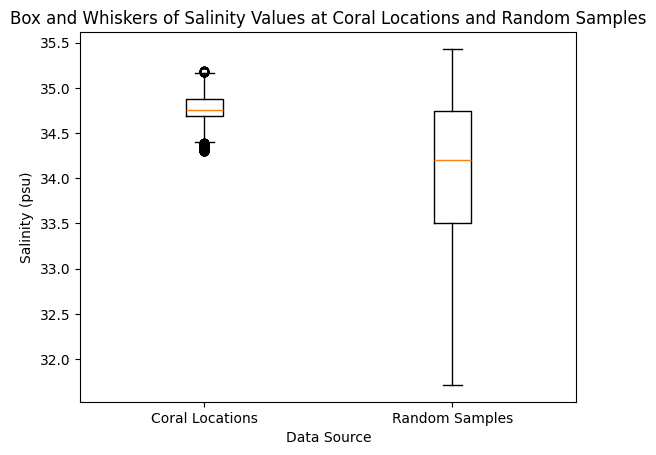

In [21]:
salinity_coral = coral_values_salinity_flat
salinity_random = random_values_salinity_flat

salinity_data = [salinity_coral, salinity_random]

labels = ['Coral Locations', 'Random Samples']

plt.boxplot(salinity_data, labels=labels)

plt.xlabel('Data Source')
plt.ylabel('Salinity (psu)')
plt.title('Box and Whiskers of Salinity Values at Coral Locations and Random Samples')

plt.show()

/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/2497872829.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(temp_data, labels=labels)


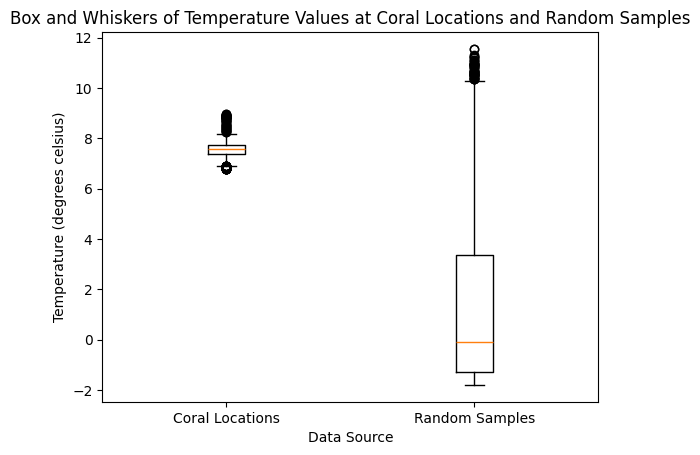

In [22]:
temp_coral = coral_values_temp_flat
temp_random = random_values_temp_flat

temp_data = [temp_coral, temp_random]

labels = ['Coral Locations', 'Random Samples']

plt.boxplot(temp_data, labels=labels)

plt.xlabel('Data Source')
plt.ylabel('Temperature (degrees celsius)')
plt.title('Box and Whiskers of Temperature Values at Coral Locations and Random Samples')

plt.show()

/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/1878144857.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(current_speed_data, labels=labels)


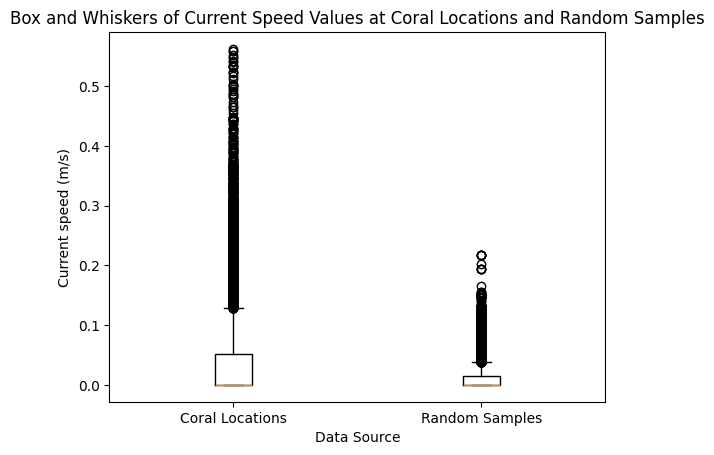

In [23]:
current_speed_coral = coral_values_current_speed_flat
current_speed_random = random_values_current_speed_flat

current_speed_data = [current_speed_coral, current_speed_random]

labels = ['Coral Locations', 'Random Samples']

plt.boxplot(current_speed_data, labels=labels)

plt.xlabel('Data Source')
plt.ylabel('Current speed (m/s)')
plt.title('Box and Whiskers of Current Speed Values at Coral Locations and Random Samples')

plt.show()

/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/3811443990.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(northness_data, labels=labels)


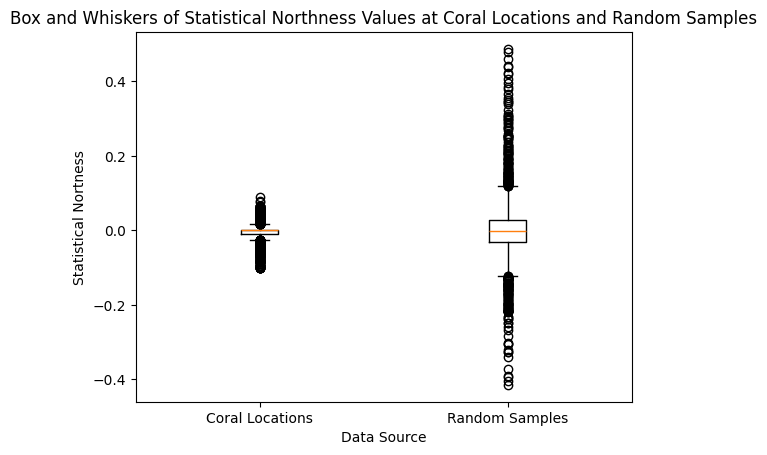

In [24]:
statistical_northness_coral = coral_values_north_flat
statistical_northness_random = random_values_north_flat

northness_data = [statistical_northness_coral, statistical_northness_random]

labels = ['Coral Locations', 'Random Samples']

plt.boxplot(northness_data, labels=labels)

plt.xlabel('Data Source')
plt.ylabel('Statistical Nortness')
plt.title('Box and Whiskers of Statistical Northness Values at Coral Locations and Random Samples')

plt.show()



/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/3757936118.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(eastness_data, labels=labels)


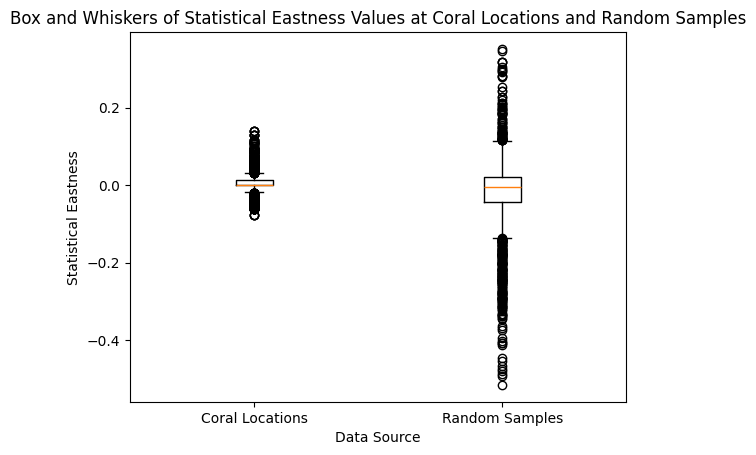

In [25]:
statistical_eastness_coral = coral_values_east_flat
statistical_eastness_random = random_values_east_flat

eastness_data = [statistical_eastness_coral, statistical_eastness_random]

labels = ['Coral Locations', 'Random Samples']

plt.boxplot(eastness_data, labels=labels)

plt.xlabel('Data Source')
plt.ylabel('Statistical Eastness')
plt.title('Box and Whiskers of Statistical Eastness Values at Coral Locations and Random Samples')

plt.show()


# Standardisation

In [27]:
# Standardize the temperature, salinity, current_speed data, and statistical northness and eastness

# Many options for what sort of standardisation we want here, but a simple one:
# Initialize the StandardScaler
scaler = StandardScaler()

temp_standardized = []
salinity_standardized = []
current_speed_standardized = []
statistical_northness_standardized = []
statistical_eastness_standardized = []


for i in range(0,309):
    temp = PhysStates_data.variables['temperature'][i]
    temperature_stand = scaler.fit_transform(temp.reshape(-1, 1)).reshape(temp.shape)
    temp_standardized.append(temperature_stand)

    salinity = PhysStates_data.variables['salinity'][i]
    salinity_stand = scaler.fit_transform(salinity.reshape(-1, 1)).reshape(salinity.shape)
    salinity_standardized.append(salinity_stand)

    current_speed = np.sqrt(PhysStates_data.variables['u_velocity'][i]**2 + PhysStates_data.variables['v_velocity'][i]**2)
    current_speed_stand = scaler.fit_transform(current_speed.reshape(-1, 1)).reshape(current_speed.shape)
    current_speed_standardized.append(current_speed_stand)

    statistical_northness = PhysStates_data.variables['u_velocity'][i] * np.cos(np.deg2rad(90)) - PhysStates_data.variables['v_velocity'][i] * np.sin(np.deg2rad(90))
    statistical_northness_stand = scaler.fit_transform(statistical_northness.reshape(-1, 1)).reshape(statistical_northness.shape)
    statistical_northness_standardized.append(statistical_northness_stand)

    statistical_eastness = PhysStates_data.variables['u_velocity'][i] * np.sin(np.deg2rad(90)) + PhysStates_data.variables['v_velocity'][i] * np.cos(np.deg2rad(90))
    statistical_eastness_stand = scaler.fit_transform(statistical_eastness.reshape(-1, 1)).reshape(statistical_eastness.shape)
    statistical_eastness_standardized.append(statistical_eastness_stand)




    





                

/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/3625146112.py:23: RuntimeWarning: invalid value encountered in sqrt
  current_speed = np.sqrt(PhysStates_data.variables['u_velocity'][i]**2 + PhysStates_data.variables['v_velocity'][i]**2)
/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/3625146112.py:23: RuntimeWarning: invalid value encountered in sqrt
  current_speed = np.sqrt(PhysStates_data.variables['u_velocity'][i]**2 + PhysStates_data.variables['v_velocity'][i]**2)
/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/3625146112.py:23: RuntimeWarning: invalid value encountered in sqrt
  current_speed = np.sqrt(PhysStates_data.variables['u_velocity'][i]**2 + PhysStates_data.variables['v_velocity'][i]**2)
/var/folders/lp/b8gl_n2n147_vxm1c97d933m0000gn/T/ipykernel_65747/3625146112.py:23: RuntimeWarning: invalid value encountered in sqrt
  current_speed = np.sqrt(PhysStates_data.variables['u_velocity'][i]**2 + PhysStates_data.variables['v_ve

In [28]:
temp_standardized = np.array(temp_standardized)
salinity_standardized = np.array(salinity_standardized)
current_speed_standardized = np.array(current_speed_standardized)
statistical_northness_standardized = np.array(statistical_northness_standardized)
statistical_eastness_standardized = np.array(statistical_eastness_standardized)

In [29]:


# Print the mean and standard deviation of the standardised data to verify

print(f"Standardised Temperature - Mean: {temp_standardized.mean():.2f}, Std Dev: {temp_standardized.std():.2f}")
print(f"Standardised Salinity - Mean: {salinity_standardized.mean():.2f}, Std Dev: {salinity_standardized.std():.2f}")
print(f"Standardised Current Speed - Mean: {current_speed_standardized.mean():.2f}, Std Dev: {current_speed_standardized.std():.2f}")
print(f"Standardised Statistical Northness - Mean: {statistical_northness_standardized.mean():.2f}, Std Dev: {statistical_northness_standardized.std():.2f}")
print(f"Standardised Statistical Eastness - Mean: {statistical_eastness_standardized.mean():.2f}, Std Dev: {statistical_eastness_standardized.std():.2f}")
                                       


Standardised Temperature - Mean: 0.00, Std Dev: 1.00
Standardised Salinity - Mean: -0.00, Std Dev: 1.00
Standardised Current Speed - Mean: -0.00, Std Dev: 1.00
Standardised Statistical Northness - Mean: -0.00, Std Dev: 1.00
Standardised Statistical Eastness - Mean: -0.00, Std Dev: 1.00


# Dividing features into min, mean and max 

In [38]:
#Temperature

#Sundahl way of dividing
temp_may_march_standardized = temp_standardized[60:151]
temp_oct_dec_standardized = temp_standardized[274:] 

temp_min_may_march = np.mean(temp_may_march_standardized)
temp_max_oct_dec = np.mean(temp_oct_dec_standardized)


#Our way
temp_min_standardized = temp_standardized.min()
temp_max_standardized = temp_standardized.max()


In [39]:
#Salinity

#Sundahl way of dividing
salinity_min10t_h_percentile_standardized = np.percentile(salinity_standardized, 10)
salinity_max_90th_percentile_standardized = np.percentile(salinity_standardized, 90)
salinity_mean_standardized = salinity_standardized.mean()

#Our way
salinity_min_standardized = salinity_standardized.min()
salinity_max_standardized = salinity_standardized.max()


In [40]:
#Current speed

#Sundahl way of dividing
current_speed_max_90th_percentile_standardized = np.percentile(current_speed_standardized, 90)
current_speed_mean_standardized = current_speed_standardized.mean()

#Our way
current_speed_min_standardized = current_speed_standardized.min()
current_speed_max_standardized = current_speed_standardized.max()

In [41]:
#Current direction

#Sundahl way of dividing
#Simply divided in stat. northness and eastness

#Our way
statistical_northness_mean_standardized = statistical_northness_standardized.mean()
statistical_eastness_mean_standardized = statistical_eastness_standardized.mean()

# Exploring the coral data

In [ ]:
!pip3 install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


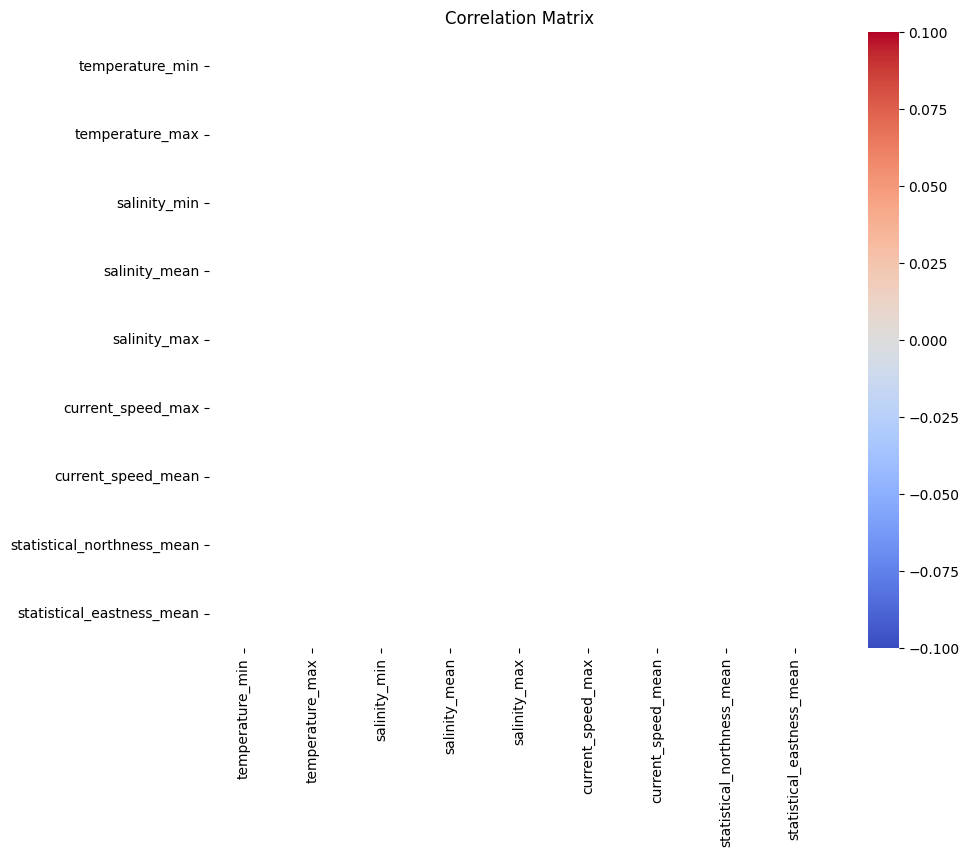

In [44]:

#Corelation matrix SUndahl features


data_sun = {
    'temperature_min': [temp_min_may_march],
    'temperature_max': [temp_max_oct_dec],
    'salinity_min': [salinity_min_10th_percentile_standardized],
    'salinity_mean': [salinity_mean_standardized],
    'salinity_max': [salinity_max_90th_percentile_standardized],
    'current_speed_max': [current_speed_max_90th_percentile_standardized],
    'current_speed_mean': [current_speed_mean_standardized],
    'statistical_northness_mean': [statistical_northness_mean_standardized],
    'statistical_eastness_mean': [statistical_eastness_mean_standardized]

}

df = pd.DataFrame(data_sun)

# Calculate the correlation matrix
correlation_matrix_sun = df.corr()

correlation_matrix_sun



plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_sun, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=0.95)  # Retain 95% of the variance

# When training, fit pca on the training data
# When transforming, transform both the training and test data
#pca.fit_transform(X_train)
#pca.transform(x_test)

df_pca = pca.fit_transform(df)




In [ ]:
for i in range(pca.n_components_):
    print(f"Principal Component {i + 1}: {pca.explained_variance_ratio_[i] * 100:.2f}%")
    for col_name in df.columns:
        print(f"{col_name}: {pca.components_[i][df.columns.get_loc(col_name)]}")

    print("\n")

Principal Component 1: 91.29%
temperature: 0.9905060496773036
salinity: 0.09225253989907173
current_speed: 0.0700505772947721
statistical_eastness: 0.04331256741805759
statistical_northness: -0.06003476125678004


Principal Component 2: 8.14%
temperature: 0.0964277368044461
salinity: 0.04048347397905183
current_speed: -0.6227651504143954
statistical_eastness: -0.284290598143964
statistical_northness: 0.7213911582114403




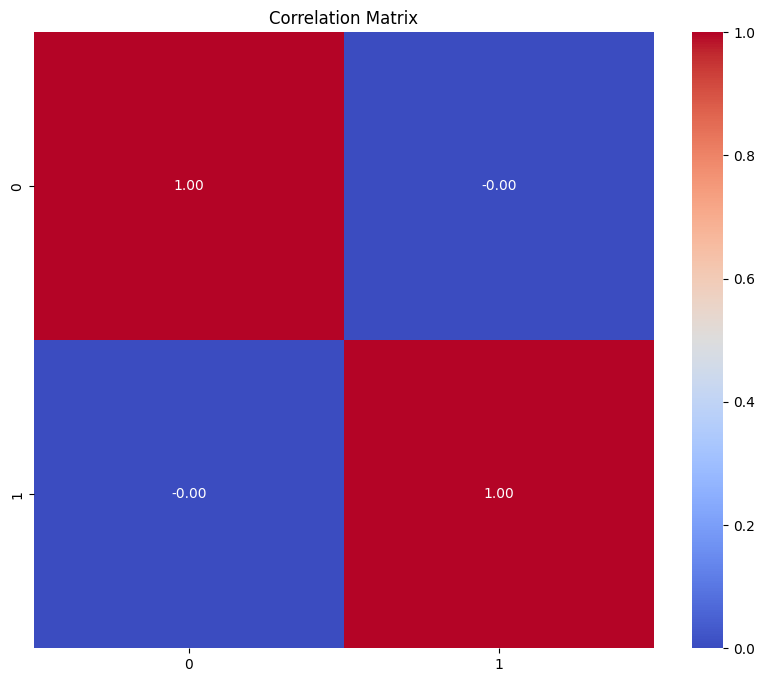

In [ ]:
correlation_matrix_pca = pd.DataFrame(df_pca).corr()

correlation_matrix



plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pca, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()